In [171]:
import pandas as pd
import json
from IPython.display import display
import os
import numpy as np
import matplotlib.pyplot as plt

In [172]:
def load_data_to_df(filepath):
    with open(filepath, 'rb') as f:
        res = json.load(f)
    res = res['results']

    df = pd.concat([pd.DataFrame(r) for r in res], axis=0, keys=range(len(res)))
    df = pd.concat([df, df['hyperparam'].apply(pd.Series)], axis=1).drop(columns='hyperparam')
    df = df.rename_axis(['rollout', 'config_id'], axis='index')
    return df


def select_hparams(df, hparam_config):
    # Select results for specific hparams
    if hparam_config:
        for key, val in hparam_config.items():
            if not isinstance(val, list):
                val = [val]
            df = df[df[key].isin(val)]
    return df


# Best hparam configs
def get_best_hparam_results(df, metric='val_loss', num_best=10000, hparam_config=None):
    if hparam_config:
        df = select_hparams(df, hparam_config)

    best = df.groupby('config_id').mean().sort_values(by=metric)[:num_best]
    return best


def get_mean_and_sem(df, test_metric='test_risk', val_metric='val_loss', hparam_config=None):
    if df.reset_index()['config_id'].nunique() > 1:
        best = get_best_hparam_results(df, metric=val_metric, num_best=1, hparam_config=hparam_config).reset_index()
        best_config_id = best.loc[0].config_id
    else:
        best_config_id = 0

    df = df.reset_index()
    df = df[df["config_id"]==best_config_id]
    return df[test_metric].mean(), df[test_metric].sem()

def plot_validation_loss(df, config_id):
    for rollout in range(df.reset_index()['rollout'].nunique()):
        plt.plot(df.loc[rollout].loc[config_id].train_stats['val_loss'])
        
    plt.title(f'val_loss: {df.loc[rollout].loc[config_id].val_loss_func}')
    print(df.groupby('config_id').mean().loc[config_id])
    
def plot_val_loss_opt(df, config_id):
    df = df.reset_index()
    df = df[df['config_id'] == config_id].reset_index()
    
    fig, ax = plt.subplots(1, 4, figsize=(LINE_WIDTH*2, LINE_WIDTH/2))

    for i, val_loss in enumerate(['val_moment', 'val_mmr', 'val_hsic', 'bennett_val_risk']):
        for rollout in range(len(df)):
            ax[i].plot(df.loc[rollout].train_stats[val_loss][:1000])

        ax[i].set_title(f'{val_loss}')
    print(kmm.groupby('config_id').mean().loc[config_id])

In [173]:
# Merge datasets
def load_and_merge_datasets(filepaths=None, property_dict=None, merge='hparam_configs', load_all_in_dir=None, method=None):
    assert (load_all_in_dir and method) or (load_all_in_dir is None and method is None)
    
    if isinstance(filepaths, str):
        filepaths = [filepaths]
    elif filepaths is None and load_all_in_dir:
        filelist = os.listdir(load_all_in_dir)
        filepaths = []
        for fp in filelist:
            if method in fp:
                filepaths.append(load_all_in_dir + fp)
        
    if merge == 'rollouts':
        merge_property = 'rollout'
    elif merge == 'hparam_configs':
        merge_property = 'config_id'
    else:
        raise NotImplementedError
    
    if not property_dict:
        prop_name = 'version'
        vals = range(len(filepaths))
    else:
        prop_name = list(property_dict.keys())[0]
        vals = property_dict[prop_name]
        
    start_merge_id = 0
    dfs = []
                
    successful = 0
    for filepath, prop in zip(filepaths, vals):
        try:
            # print(filepath)
            data_frame = load_data_to_df(filepath)
            data_frame = data_frame.drop(columns=['test_risk_optim', 'parameter_mse_optim', 'best_index'])
            data_frame[prop_name] = prop

            # Add new config id
            data_frame = data_frame.reset_index()
            data_frame[merge_property] += start_merge_id
            start_merge_id = data_frame[merge_property].max() + 1
            dfs.append(data_frame)
            successful += 1
        except:# FileNotFoundError or JSONDecodeError:
            pass
            # print('File not found:', filepath)
    print(f'Found {successful}/{len(filepaths)} files.')

    df = pd.concat(dfs, ignore_index=True)
    df = df.set_index(['rollout', 'config_id'])
    return df

filepath1 = '../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json'
filepath2 = '../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json'
fps = [filepath1, filepath2]
property_dict = {'divergence': ['kl', 'log']}

df1 = load_data_to_df(filepath1)
df2 = load_data_to_df(filepath2)
df3 = load_and_merge_datasets(fps, property_dict)

print(get_mean_and_sem(df1))
print(get_mean_and_sem(df2))
print(get_mean_and_sem(df3))

best = get_best_hparam_results(df3, metric='test_risk')
best

df = load_and_merge_datasets('../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json')
best = get_best_hparam_results(df, metric='test_risk', num_best=20)
best

# EXP1: Bennett Hetero

In [188]:
n = 2000


vmm = load_and_merge_datasets(load_all_in_dir=f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero_new/n_{n}/",
                              method="VMM-neural", merge='rollouts')
    
fgel = load_and_merge_datasets(load_all_in_dir=f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero_new/n_{n}/",
                              method="FGEL-neural", merge='rollouts')    
    
kmm = load_and_merge_datasets(load_all_in_dir=f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero_new/n_{n}/",
                              method="KMM")

kmm['config'] = kmm['config'].astype(int)
kmm = kmm.reset_index().drop(columns=['rollout', 'config_id'])
kmm = kmm.set_index('config').rename_axis(index='config_id')

Found 10/10 files.
Found 10/10 files.
Found 270/270 files.


## VMM

In [189]:
best_vmm = get_best_hparam_results(vmm, metric='val_loss', hparam_config={})#'reg_param': [0, 1e-4, 1e-2, 1e0]})
best_vmm

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
3,0.182049,0.102368,0.014220,1.0000,4.5
0,0.166960,0.089106,0.014595,0.0000,4.5
2,0.165181,0.070862,0.014685,0.0100,4.5
1,0.182924,0.129922,0.015745,0.0001,4.5


test_risk                0.138521
mse                      0.179111
val_loss                 0.008972
n_reference_samples      0.000000
entropy_reg_param        1.000000
reg_param                1.000000
version                145.400000
Name: 2, dtype: float64


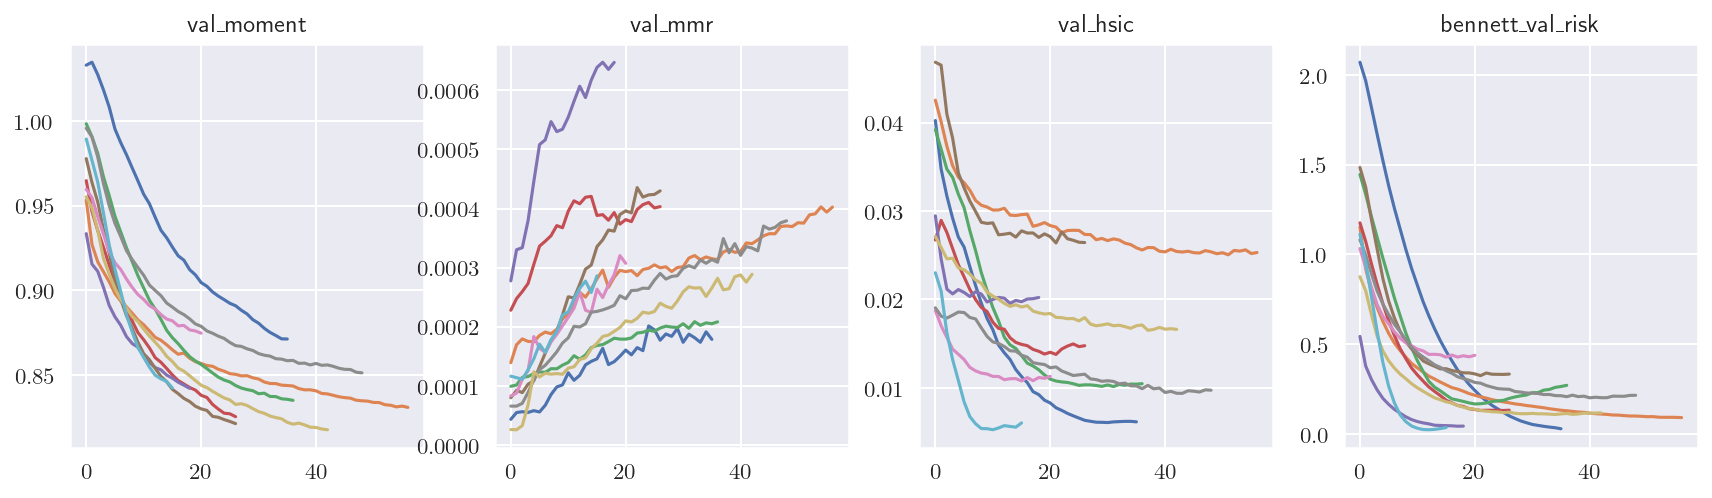

In [190]:
plot_val_loss_opt(vmm, config_id=2)

## FGEL

In [216]:
best_fgel = get_best_hparam_results(fgel, metric='val_loss', hparam_config={
                                                                           # 'reg_param': [0, 1e-4, 1e-2, 1e0],
                                                                        'divergence': 'kl',
                                                                           })
best_fgel

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
4,0.153705,0.202524,0.009538,0.0001,4.5
1,0.142120,0.158544,0.009669,0.0000,4.5
7,0.157816,0.187473,0.009696,0.0100,4.5
10,0.138220,0.062631,0.012567,1.0000,4.5


test_risk                0.314691
mse                      0.444288
val_loss                 0.012122
n_reference_samples      0.000000
entropy_reg_param      100.000000
reg_param                0.010000
version                121.200000
Name: 6, dtype: float64


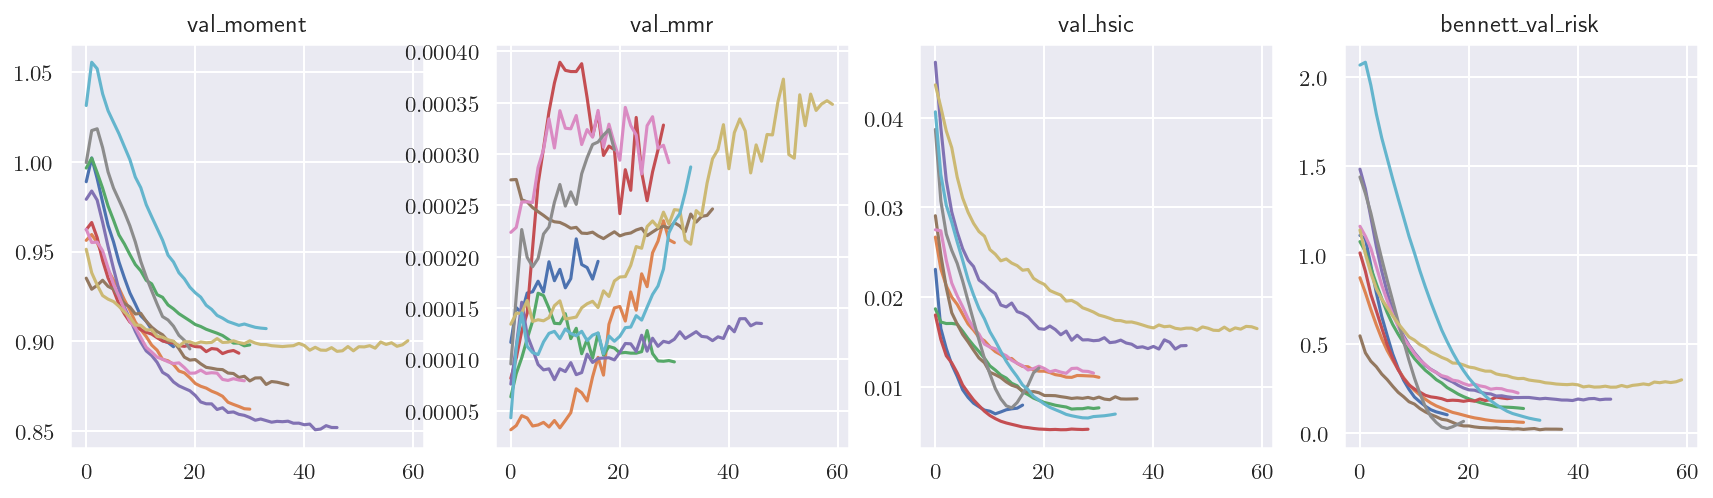

In [192]:
plot_val_loss_opt(fgel, config_id=6)

## KMM

In [193]:
best_kmm = get_best_hparam_results(kmm, metric='val_loss', hparam_config={
                                                                            "n_reference_samples": [200],
    # "entropy_reg_param": 1.0,
    # "reg_param": 1.0,
                                                                            # 'entropy_reg_param': [10]
                                                                            # 'val_loss_func': 'hsic',
                                                                         #'reg_param': [0, 1e-4, 1e-2, 1e0],
                                                                        })
best_kmm

,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,version
config_id,,,,,,,
11,0.125595,0.143867,0.009075,200.0,1.0,1.00,119.3
14,0.128026,0.149846,0.009199,200.0,10.0,1.00,149.1
17,0.130065,0.150895,0.009229,200.0,100.0,1.00,147.5
9,0.163610,0.227529,0.009323,200.0,1.0,0.01,147.5
10,0.161500,0.224687,0.009380,200.0,1.0,0.10,121.3
13,0.202409,0.306369,0.010407,200.0,10.0,0.10,117.0
16,0.222201,0.340649,0.010545,200.0,100.0,0.10,120.4
12,0.257398,0.400937,0.011575,200.0,10.0,0.01,145.2
15,0.327017,0.460839,0.012391,200.0,100.0,0.01,148.5


test_risk                0.125595
mse                      0.143867
val_loss                 0.009075
n_reference_samples    200.000000
entropy_reg_param        1.000000
reg_param                1.000000
version                119.300000
Name: 11, dtype: float64


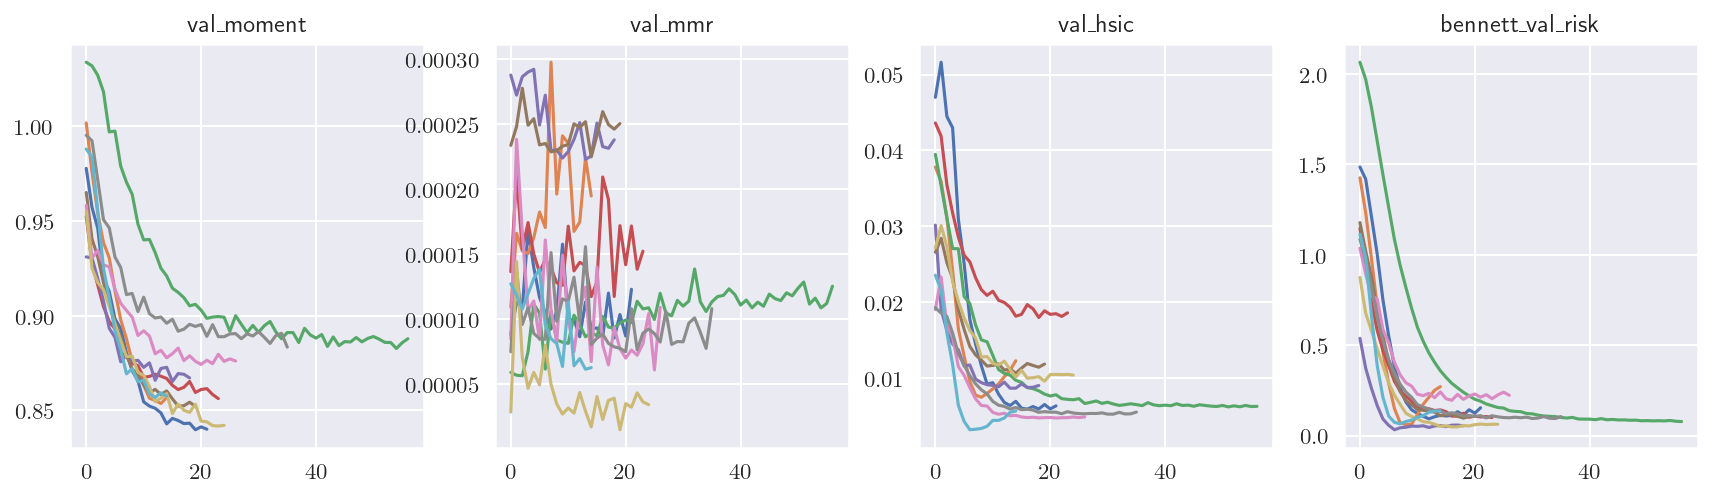

In [194]:
plot_val_loss_opt(kmm, config_id=11)

In [199]:
get_mean_and_sem(kmm, test_metric='test_risk', val_metric='val_loss', hparam_config={
                                       "n_reference_samples": [200], 
                                       #"entropy_reg_param": [1],
                                       #"reg_param": [1]
}
                )

(0.1255947440867615, 0.020039654265241402)

In [222]:
def generate_table_bennett(methods, kmm_hparam_config={}):
    n_trains = [2000, 4000]
    
    results = {n_train: {model: {} for model in methods} for n_train in n_trains}
    for n_train in n_trains:
        path = f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero_new/n_{n_train}/"
        for method in methods:
            if method == 'KMM':
                hparam_config = kmm_hparam_config
            elif method == 'FGEL-neural':
                hparam_config = {'divergence': 'kl'}
            else:
                hparam_config = {}

            
            
            if method == 'KMM':
                df = load_and_merge_datasets(load_all_in_dir=path, method=method)
                df['config'] = df['config'].astype(int)
                df = df.reset_index().drop(columns=['rollout', 'config_id'])
                df = df.set_index('config').rename_axis(index='config_id')
            else:  
                df = load_and_merge_datasets(load_all_in_dir=path, method=method, merge='rollouts')
            mean, sem = get_mean_and_sem(df, test_metric='test_risk', val_metric='val_loss',
                                         hparam_config=hparam_config)

            results[n_train][method] = {'mean': mean, 'sem': sem}

    row1 = [''] + [model for model in methods]
    table = [row1]
    for n_train in n_trains:
        table.append([f'n={n_train}'] + [
            r"${:.2f}\pm{:.2f}$".format(results[n_train][model]["mean"], results[n_train][model]["sem"]) for
            model in results[n_train].keys()])
    print(tabulate(table, tablefmt="latex_raw"))

In [223]:
methods = ['OLS', 'SMD', "MMR", 'DeepIV', 'VMM-neural', 'FGEL-neural', 'KMM']
generate_table_bennett(methods, kmm_hparam_config={"n_reference_samples": [200], })

Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 270/270 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 270/270 files.
\begin{tabular}{llllllll}
\hline
        & OLS           & SMD           & MMR           & DeepIV        & VMM-neural    & FGEL-neural   & KMM           \\
 n=2000 & $5.74\pm0.13$ & $2.74\pm1.11$ & $1.19\pm0.12$ & $1.49\pm0.08$ & $0.18\pm0.04$ & $0.15\pm0.06$ & $0.13\pm0.02$ \\
 n=4000 & $5.65\pm0.10$ & $2.23\pm0.98$ & $0.94\pm0.12$ & $1.40\pm0.08$ & $0.09\pm0.01$ & $0.07\pm0.02$ & $0.09\pm0.02$ \\
\hline
\end{tabular}


KeyError: 'rkhs_func_z_dependent'

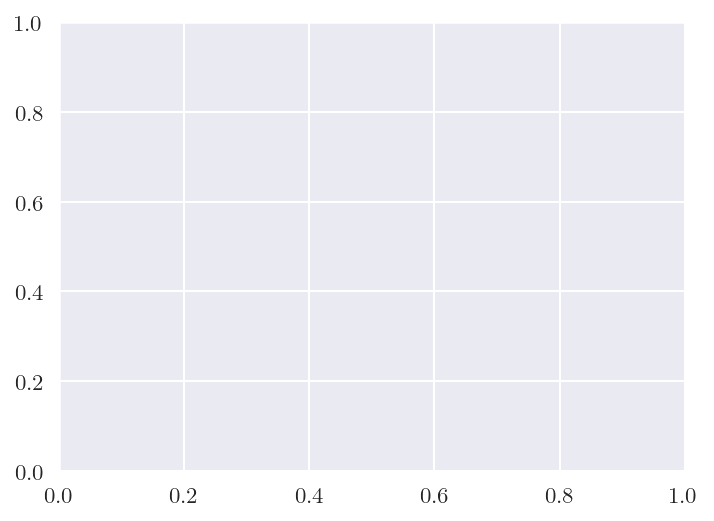

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
from cmr.utils.plot import NEURIPS_RCPARAMS, LINE_WIDTH

plt.rcParams.update(NEURIPS_RCPARAMS)
sns.set_theme()
figsize = (LINE_WIDTH/1.3, LINE_WIDTH / 1.8)

fig, ax = plt.subplots(1, 1, figsize=figsize)

n_refs = [0, 100, 200]
for divergence in ['kl']:
    mean = []
    std = []
    for n_ref in n_refs:
        m, s = get_mean_and_sem(kmm, test_metric='test_risk', val_metric='val_loss', hparam_config={'rkhs_func_z_dependent': 1.0,
                                       "n_reference_samples": n_ref, 
                                       "entropy_reg_param": [1],
                                       "reg_param": [1],
                                       'divergence': divergence})
        mean.append(m)
        std.append(s)
    ax.errorbar(n_refs, mean, std)
    

# EXP1.1: Bennett Hetero Optimization Parameters

In [45]:
n = 2000
kmm = load_and_merge_datasets(load_all_in_dir=f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero_opt/n_{n}/",
                              method="KMM")
kmm['config'] = kmm['config'].astype(int)
kmm = kmm.reset_index().drop(columns=['rollout', 'config_id'])
kmm = kmm.set_index('config').rename_axis(index='config_id')
kmm

Found 236/236 files.


,test_risk,mse,val_loss,train_stats,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,theta_lr,dual_lr,batch_size,max_num_epochs,max_no_improve,version
config_id,,,,,,,,,,,,,,,
15,0.485348,0.988587,0.837392,"{'epochs': 29999, 'val_loss': [0.9999800324440...",0.0,1.0,1.0,0.1,10000.0,0.00010,0.00005,1000.0,30000.0,inf,0
15,0.171300,0.310243,0.848126,"{'epochs': 29999, 'val_loss': [0.9895005822181...",0.0,1.0,1.0,0.1,10000.0,0.00010,0.00005,1000.0,30000.0,inf,0
19,0.754912,0.688001,0.901468,"{'epochs': 29999, 'val_loss': [0.9613803029060...",0.0,1.0,1.0,0.1,10000.0,0.00005,0.00050,1000.0,30000.0,inf,1
19,0.186625,0.405619,0.866325,"{'epochs': 29999, 'val_loss': [0.9345015287399...",0.0,1.0,1.0,0.1,10000.0,0.00005,0.00050,1000.0,30000.0,inf,1
4,0.071971,0.084663,0.861535,"{'epochs': 29999, 'val_loss': [1.0339361429214...",0.0,1.0,1.0,0.1,10000.0,0.00050,0.00010,200.0,30000.0,inf,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.256989,0.288294,0.793162,"{'epochs': 29999, 'val_loss': [0.9560664296150...",200.0,1.0,1.0,0.1,10000.0,0.00050,0.00250,1000.0,30000.0,inf,233
34,0.129713,0.252159,0.832275,"{'epochs': 29999, 'val_loss': [0.9519304633140...",200.0,1.0,1.0,0.1,10000.0,0.00010,0.00050,200.0,30000.0,inf,234
34,0.286340,0.093240,0.809972,"{'epochs': 29999, 'val_loss': [0.9794697165489...",200.0,1.0,1.0,0.1,10000.0,0.00010,0.00050,200.0,30000.0,inf,234


In [51]:
best_kmm = get_best_hparam_results(kmm, metric='test_risk', hparam_config={'n_reference_samples': [200],
                                                                           #'batch_size': [1000],
                                                                           'theta_lr': [5e-4],
                                                                           'dual_lr': [1e-4],
    #'val_loss_func': val_loss_func
})
best_kmm

,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,theta_lr,dual_lr,batch_size,max_num_epochs,max_no_improve,version
config_id,,,,,,,,,,,,,,
28,0.133306,0.068222,0.841537,200.0,1.0,1.0,0.1,10000.0,0.0005,0.0001,200.0,30000.0,NaN,139.25
29,0.143990,0.141739,0.845649,200.0,1.0,1.0,0.1,10000.0,0.0005,0.0001,1000.0,30000.0,NaN,139.80


test_risk                  0.133306
mse                        0.068222
val_loss                   0.841537
n_reference_samples      200.000000
entropy_reg_param          1.000000
reg_param                  1.000000
kde_bw                     0.100000
n_random_features      10000.000000
theta_lr                   0.000500
dual_lr                    0.000100
batch_size               200.000000
max_num_epochs         30000.000000
max_no_improve                  NaN
version                  139.250000
Name: 28, dtype: float64


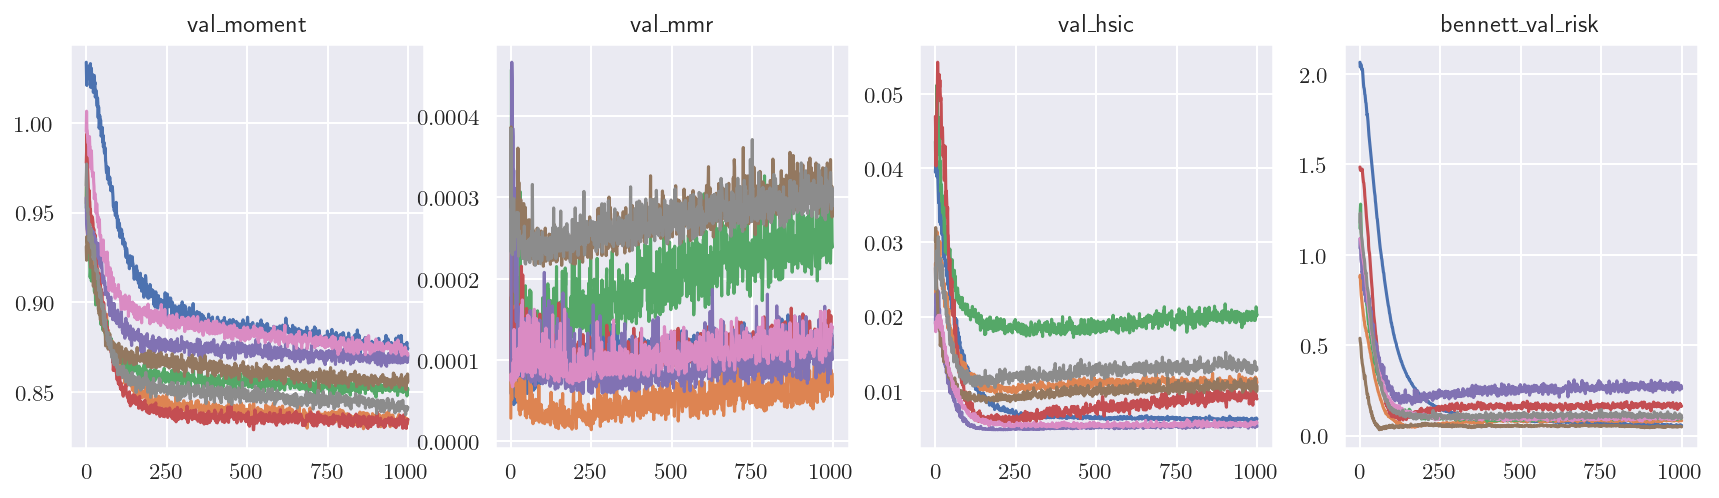

In [63]:
plot_val_loss_opt(kmm, config_id=28)

# EXP2: Network IV

## Load Data

In [137]:
func = 'step'
app = ''

vmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv{app}/{func}/',
                              method="VMM-neural", merge='rollouts')
    
    
fgel = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv{app}/{func}/',
                              method="FGEL-neural", merge='rollouts')    
    
kmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv{app}/{func}/',
                              method="KMM")

kmm['config'] = kmm['config'].astype(int)
kmm = kmm.reset_index().drop(columns=['rollout', 'config_id'])
kmm = kmm.set_index('config').rename_axis(index='config_id')

Found 10/10 files.
Found 10/10 files.
Found 1080/1080 files.


## VMM

In [221]:
func = 'abs'

vmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv{app}/{func}/',
                              method="VMM-neural", merge='rollouts')

best_vmm = get_best_hparam_results(vmm, metric='val_loss', hparam_config={})
best_vmm

Found 10/10 files.


,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
0,0.022246,0.0,0.015772,0.0000,4.5
1,0.017845,0.0,0.015966,0.0001,4.5
2,0.029572,0.0,0.017849,0.0100,4.5
3,0.019882,0.0,0.018346,1.0000,4.5


test_risk                  0.056025
mse                        0.000000
val_loss                   0.017122
n_reference_samples        0.000000
entropy_reg_param          1.000000
reg_param                  0.055000
version                  465.050000
n_random_features       2000.000000
theta_lr                   0.000100
max_num_epochs         15000.000000
Name: 1, dtype: float64


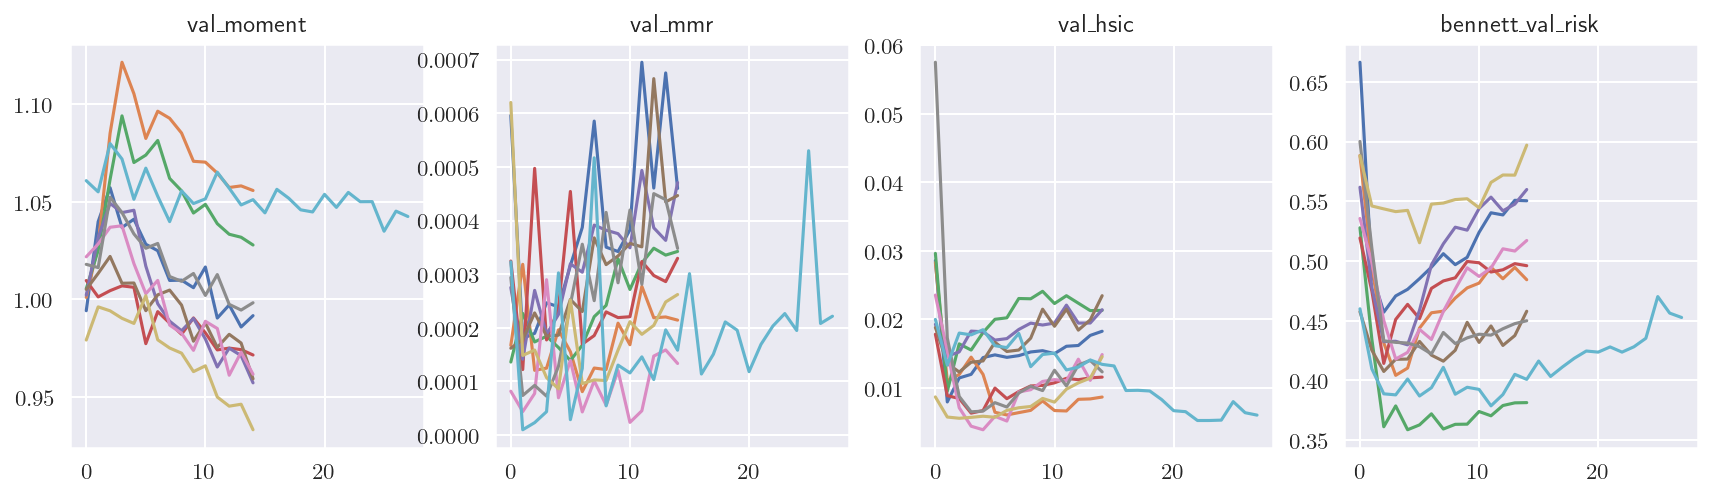

In [139]:
plot_val_loss_opt(vmm, config_id=1)

## FGEL

In [140]:
best_fgel = get_best_hparam_results(fgel, metric='val_loss', hparam_config={})
best_fgel

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
11,0.024129,0.0,0.013994,1.0000,4.5
10,0.025530,0.0,0.014496,1.0000,4.5
4,0.054859,0.0,0.014800,0.0001,4.5
6,0.049366,0.0,0.016931,0.0100,4.5
9,0.032143,0.0,0.017867,1.0000,4.5
0,0.053750,0.0,0.018117,0.0000,4.5
3,0.064994,0.0,0.019147,0.0001,4.5
2,0.090978,0.0,0.022942,0.0000,4.5
8,0.108688,0.0,0.024568,0.0100,4.5


test_risk                  0.068442
mse                        0.000000
val_loss                   0.022026
n_reference_samples      100.000000
entropy_reg_param          5.500000
reg_param                  0.055000
version                  510.050000
n_random_features       2000.000000
theta_lr                   0.000100
max_num_epochs         15000.000000
Name: 10, dtype: float64


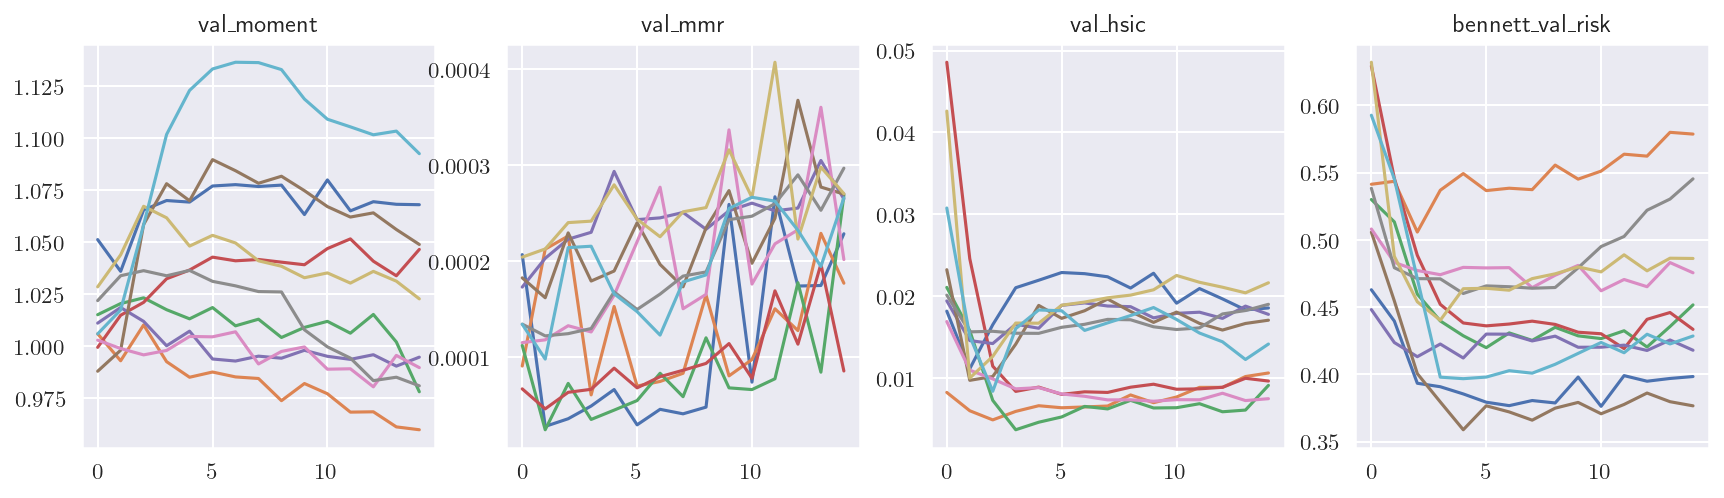

In [141]:
plot_val_loss_opt(fgel, config_id=10)

## KMM

In [165]:
best_kmm = get_best_hparam_results(kmm, metric='val_loss', hparam_config={
                    
#                                                                       'entropy_reg_param': 1.0,
#                                                                       'reg_param': 1.0,
                                                                      'n_reference_samples': [200],
    'theta_lr': [5e-5]
                                                                     })
best_kmm

,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,version,n_random_features,theta_lr,max_num_epochs
config_id,,,,,,,,,,
35,0.022365,0.0,0.011718,200.0,1.0,1.00,573.7,2000.0,0.00005,15000.0
32,0.025239,0.0,0.012046,200.0,1.0,0.10,510.7,2000.0,0.00005,15000.0
29,0.026679,0.0,0.012119,200.0,1.0,0.01,470.2,2000.0,0.00005,15000.0
53,0.022564,0.0,0.012178,200.0,100.0,1.00,620.9,2000.0,0.00005,15000.0
44,0.022126,0.0,0.012236,200.0,10.0,1.00,511.6,2000.0,0.00005,15000.0
41,0.029882,0.0,0.016905,200.0,10.0,0.10,510.2,2000.0,0.00005,15000.0
50,0.029582,0.0,0.017243,200.0,100.0,0.10,618.4,2000.0,0.00005,15000.0
38,0.039005,0.0,0.020445,200.0,10.0,0.01,577.6,2000.0,0.00005,15000.0
47,0.039836,0.0,0.022364,200.0,100.0,0.01,516.1,2000.0,0.00005,15000.0


test_risk                  0.053494
mse                        0.000000
val_loss                   0.020420
n_reference_samples      100.000000
entropy_reg_param          5.500000
reg_param                  0.505000
version                  523.750000
n_random_features       2000.000000
theta_lr                   0.000050
max_num_epochs         15000.000000
Name: 11, dtype: float64


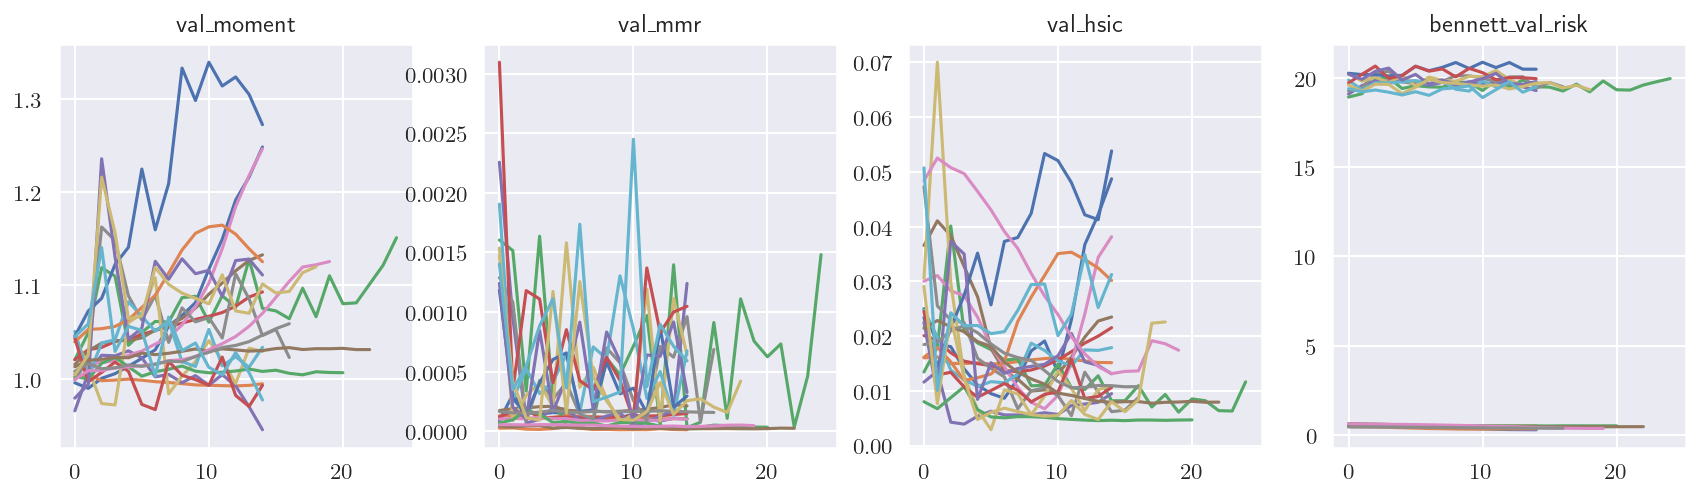

In [158]:
plot_val_loss_opt(kmm, config_id=11)

In [219]:
from tabulate import tabulate

def generate_table_network_iv(n_train, methods, kmm_hparam_config={}, small=False):
    funcs = ['abs', 'step', 'sin', 'linear']
    
    if small:
        app = "_small"
    else:
        app = ''
    
    results = {func: {model: {} for model in methods} for func in funcs}
    for func in funcs:
        path = f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv{app}/{func}/"
        for method in methods:
            if method == "KMM":
                hparam_config = kmm_hparam_config
            elif method == 'FGEL-neural':
                hparam_config = {'divergence': 'kl'}
            else:
                hparam_config = {}

            
            if method == 'KMM':
                df = load_and_merge_datasets(load_all_in_dir=path, method=method)
                df['config'] = df['config'].astype(int)
                df = df.reset_index().drop(columns=['rollout', 'config_id'])
                df = df.set_index('config').rename_axis(index='config_id')
            else:  
                df = load_and_merge_datasets(load_all_in_dir=path, method=method, merge='rollouts')
            mean, sem = get_mean_and_sem(df, test_metric='test_risk', val_metric='val_loss',
                                         hparam_config=hparam_config)

            results[func][method] = {'mean': mean, 'sem': sem}

    row1 = [''] + [model for model in methods]
    table = [row1]
    for func in funcs:
        table.append([f'{func}'] + [
            r"${:.2f}\pm{:.2f}$".format(results[func][model]["mean"] * 1e1, results[func][model]["sem"] * 1e1) for
            model in results[func].keys()])
    print(tabulate(table, tablefmt="latex_raw"))

In [220]:
methods = ['OLS', 'SMD', "MMR", 'DeepIV', 'VMM-neural', 'FGEL-neural', 'KMM']

hparam_config={
              #'entropy_reg_param': 1.0,
              #'reg_param': 1.0,
              # 'n_reference_samples': [200], 
              # 'theta_lr': [1e-4],
              #'n_reference_samples': [200],
              #"n_random_features": 10000,
             # "rkhs_reg_param": np.nan,
              }

generate_table_network_iv(n_train=None, methods=methods, kmm_hparam_config=hparam_config, small=False)

Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 1078/1078 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 1080/1080 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 1080/1080 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 10/10 files.
Found 1076/1076 files.
\begin{tabular}{llllllll}
\hline
        & OLS           & SMD           & MMR           & DeepIV        & VMM-neural    & FGEL-neural   & KMM           \\
 abs    & $3.27\pm0.40$ & $1.36\pm1.23$ & $1.38\pm1.03$ & $2.60\pm1.49$ & $0.22\pm0.04$ & $0.56\pm0.25$ & $0.14\pm0.04$ \\
 step   & $3.03\pm0.13$ & $0.25\pm0.03$ & $0.50\pm0.05$ & $0.66\pm0.06$ & $0.28\pm0.04$ & $0.26\pm0.03$ & $0.26\pm0.03$ \\
 sin    & $3.25\pm0.06$ & $1.39\pm0.12$ & $2.68\pm

In [33]:
methods = ['OLS', 'SMD', "MMR", 'DeepIV', 'VMM-neural', 'FGEL-neural', 'KMM']

hparam_config={'val_loss_func': val_loss_func,
              'n_reference_samples': [200],
              "n_random_features": 10000,
              "rkhs_reg_param": np.nan,}

generate_table_network_iv(n_train=None, methods=methods, val_loss_func='moment_violation', kmm_hparam_config=hparam_config)

Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 24/24 files.
Found 933/933 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 26/26 files.
Found 937/937 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 28/28 files.
Found 931/931 files.
\begin{tabular}{llllllll}
\hline
      & OLS           & SMD           & MMR           & DeepIV        & VMM-neural    & FGEL-neural   & KMM           \\
 abs  & $3.27\pm0.40$ & $1.37\pm1.23$ & $1.40\pm1.06$ & $2.60\pm1.49$ & $0.17\pm0.04$ & $0.18\pm0.04$ & $0.15\pm0.02$ \\
 step & $2.95\pm0.10$ & $0.25\pm0.03$ & $0.50\pm0.05$ & $0.66\pm0.06$ & $0.26\pm0.06$ & $0.28\pm0.02$ & $0.26\pm0.02$ \\
 sin  & $3.27\pm0.07$ & $1.28\pm0.11$ & $2.54\pm0.29$ & $3.62\pm0.27$ & $0.86\pm0.08$ & $0.86\pm0.09$ & $0.89\pm0.09$ \\
\hline
\end{tabular}


In [34]:
methods = ['OLS', 'SMD', "MMR", 'DeepIV', 'VMM-neural', 'FGEL-neural', 'KMM']

hparam_config={'val_loss_func': val_loss_func,
              'n_reference_samples': [400],
              "n_random_features": 10000,
              "rkhs_reg_param": np.nan,}

generate_table_network_iv(n_train=None, methods=methods, val_loss_func='moment_violation', kmm_hparam_config=hparam_config)

Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 24/24 files.
Found 933/933 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 26/26 files.
Found 937/937 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 28/28 files.
Found 931/931 files.
\begin{tabular}{llllllll}
\hline
      & OLS           & SMD           & MMR           & DeepIV        & VMM-neural    & FGEL-neural   & KMM           \\
 abs  & $3.27\pm0.40$ & $1.37\pm1.23$ & $1.40\pm1.06$ & $2.60\pm1.49$ & $0.17\pm0.04$ & $0.18\pm0.04$ & $0.16\pm0.02$ \\
 step & $2.95\pm0.10$ & $0.25\pm0.03$ & $0.50\pm0.05$ & $0.66\pm0.06$ & $0.26\pm0.06$ & $0.28\pm0.02$ & $0.27\pm0.02$ \\
 sin  & $3.27\pm0.07$ & $1.28\pm0.11$ & $2.54\pm0.29$ & $3.62\pm0.27$ & $0.86\pm0.08$ & $0.86\pm0.09$ & $0.83\pm0.08$ \\
\hline
\end{tabular}


# Heteroskedastic one

In [39]:
n = 1024

kmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/heteroskedastic_one/n_{n}/',
                              method="KMM")

Found 83/83 files.


In [50]:
kmm

,,test_risk,mse,val_loss,train_stats,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,rkhs_func_z_dependent,t_as_instrument,val_loss_func,version
rollout,config_id,,,,,,,,,,,,,
0,0,NaN,NaN,NaN,"{'epochs': 185, 'val_loss': [0.000480607704957...",100,0.1,0.1,1.0,10000,False,True,mmr,0
1,0,NaN,NaN,NaN,"{'epochs': 66, 'val_loss': [0.0011649376247078...",100,0.1,0.1,1.0,10000,False,True,mmr,0
2,0,NaN,NaN,NaN,"{'epochs': 57, 'val_loss': [0.0001341686584055...",100,0.1,0.1,1.0,10000,False,True,mmr,0
3,0,33.405651,0.000595,0.000080,"{'epochs': 476, 'val_loss': [8.033214544411749...",100,0.1,0.1,1.0,10000,False,True,mmr,0
4,0,32.910564,0.056124,0.003544,"{'epochs': 408, 'val_loss': [0.003541370388120...",100,0.1,0.1,1.0,10000,False,True,mmr,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,82,33.946095,0.000788,0.000380,"{'epochs': 408, 'val_loss': [0.000326164183206...",0,1.0,0.1,1.0,10000,False,True,mmr,82
6,82,34.061115,0.007493,0.000398,"{'epochs': 476, 'val_loss': [0.000304126646369...",0,1.0,0.1,1.0,10000,False,True,mmr,82
7,82,34.312687,0.001955,0.000546,"{'epochs': 408, 'val_loss': [0.000472621846711...",0,1.0,0.1,1.0,10000,False,True,mmr,82


In [52]:
best_kmm = get_best_hparam_results(kmm, metric="mse", hparam_config={'val_loss_func': 'moment_violation',
                                                                     })
best_kmm

,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,rkhs_func_z_dependent,t_as_instrument,version
config_id,,,,,,,,,,,
18,33.733530,0.003178,1.001871,200.0,1.0,0.1,0.1,10000.0,0.0,1.0,18.0
64,33.733530,0.003178,1.001871,200.0,1.0,0.1,1.0,10000.0,0.0,1.0,64.0
59,33.734203,0.003304,1.001782,100.0,1.0,0.1,0.1,10000.0,0.0,1.0,59.0
67,33.923206,0.003578,1.000039,100.0,0.1,10.0,0.1,10000.0,0.0,1.0,67.0
16,33.923206,0.003578,1.000039,100.0,0.1,10.0,1.0,10000.0,0.0,1.0,16.0
55,33.737675,0.003759,1.001757,0.0,1.0,0.1,0.1,10000.0,0.0,1.0,55.0
20,33.963175,0.003849,1.000077,100.0,0.1,1.0,1.0,10000.0,0.0,1.0,20.0
27,33.916746,0.003868,1.000033,100.0,0.1,0.1,1.0,10000.0,0.0,1.0,27.0
24,33.737927,0.003882,1.001701,0.0,1.0,0.1,1.0,10000.0,0.0,1.0,24.0


In [47]:
mean, sem = get_mean_and_sem(kmm, test_metric='mse', val_metric='val_loss')
print(mean, sem)

0.0035779720983839503 0.0030263801117826833


In [58]:
vmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/heteroskedastic_one/n_{n}/',
                              method="VMM-neural")
best_vmm = get_best_hparam_results(vmm, metric="val_loss", hparam_config={'val_loss_func': 'moment_violation',})
best_vmm

Found 10/10 files.


In [61]:
vmm

,,test_risk,mse,val_loss,train_stats,reg_param,val_loss_func,version
rollout,config_id,,,,,,,
0,0,34.490917,0.000060,1.003216,"{'epochs': 408, 'val_loss': [1.000026464462280...",0.0,moment_violation,0
1,0,33.599976,0.000550,1.001533,"{'epochs': 408, 'val_loss': [1.000175714492797...",0.0,moment_violation,0
2,0,32.550266,0.000081,1.002181,"{'epochs': 408, 'val_loss': [1.000002145767212...",0.0,moment_violation,0
3,0,33.405674,0.000314,1.000057,"{'epochs': 408, 'val_loss': [1.000005245208740...",0.0,moment_violation,0
4,0,32.691376,0.000225,1.015347,"{'epochs': 408, 'val_loss': [1.000244855880737...",0.0,moment_violation,0
...,...,...,...,...,...,...,...,...
5,9,33.959545,0.008567,0.000552,"{'epochs': 408, 'val_loss': [0.000326025299727...",10.0,mmr,9
6,9,34.033463,0.002511,0.000319,"{'epochs': 408, 'val_loss': [0.000304081884678...",10.0,mmr,9
7,9,34.354053,0.012660,0.000756,"{'epochs': 408, 'val_loss': [0.000472676969366...",10.0,mmr,9


In [64]:
best_vmm = get_best_hparam_results(vmm, metric="val_loss", hparam_config={'val_loss_func': 'moment_violation',})
best_vmm

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
6,33.837581,0.032996,0.998629,10.0000,6.0
7,33.770673,0.013234,0.999658,1.0000,7.0
8,33.724634,0.001356,1.002619,0.0100,8.0
3,33.718943,0.000370,1.002633,0.0001,3.0
0,33.718548,0.000363,1.002662,0.0000,0.0


In [79]:
val_loss_func = 'mmr'

Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 78/78 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 90/90 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 78/78 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 73/73 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 83/83 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 29/29 files.
Found 81/81 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 77/77 files.


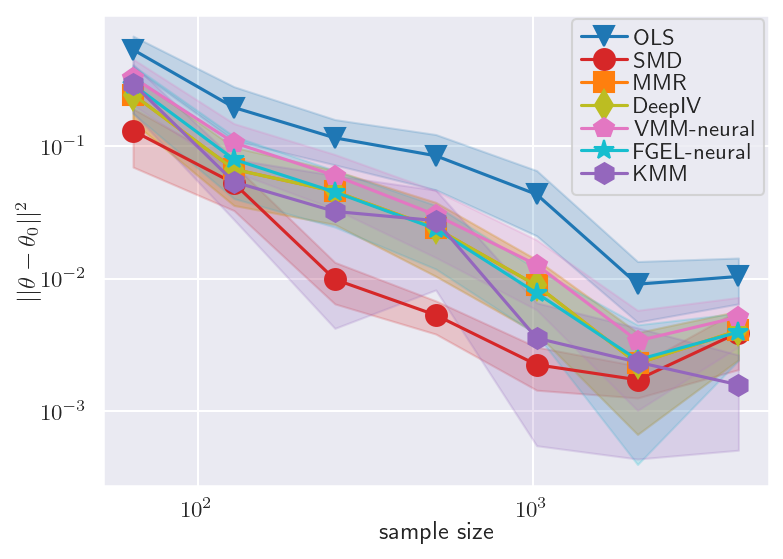

In [80]:
# def plot_results_over_sample_size(methods, n_samples, labels=None, hparam_config=None, logscale=False):

kmm_hparam_config = {}
plt.rcParams.update(NEURIPS_RCPARAMS)
sns.set_theme()

n_samples = [64, 128, 256, 512, 1024, 2048, 4096]
# if not labels:
labels = methods

marker = ['v', 'o', 's', 'd', 'p', '*', 'h'] * 2
colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:olive', 'tab:pink', 'tab:cyan', 'tab:purple'] * 2

results = {method: {'mean': [], 'sem': []} for method in methods}
n_samples = np.sort(n_samples)
for n_train in n_samples:
    for method in methods:
        hparam_config = kmm_hparam_config if method == 'KMM' else {}
        if method in ['FGEL-neural', 'VMM-neural', 'KMM']:
            hparam_config['val_loss_func'] = val_loss_func
            
        df = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/heteroskedastic_one/n_{n_train}/',
                                      method=method)
        mean, sem = get_mean_and_sem(df, test_metric='mse', val_metric='val_loss', hparam_config=hparam_config)
        results[method]['mean'].append(mean)
        results[method]['sem'].append(sem)

n_plots = 1
# figsize = (LINE_WIDTH, LINE_WIDTH / 2)
figsize = (LINE_WIDTH/1.3, LINE_WIDTH / 1.8)

fig, ax = plt.subplots(1, n_plots, figsize=figsize)
ax = [ax]

for i, (method, res) in enumerate(results.items()):
    ax[0].plot(n_samples, res['mean'], label="".join(labels[i]), color=colors[i], marker=marker[i], ms=10)
    ax[0].fill_between(n_samples,
                    np.subtract(res['mean'], res['sem']),
                    np.add(res['mean'], res['sem']),
                    alpha=0.2,
                    color=colors[i])

ax[0].set_xlabel('sample size')
ax[0].set_ylabel(r'$||\theta - \theta_0 ||^2$')
# if logscale:
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[0].set_xlim([1e2, 1e4])
# ax[0].set_ylim(ymax=1e0, ymin=1e-6) #[1e-5, 1.2e0])

plt.legend()
plt.tight_layout()
plt.savefig('exp_heteroskedastic.pdf', dpi=200)
plt.show()

In [78]:
vmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/heteroskedastic_one/n_1024/',
                              method="KMM")
best_vmm = get_best_hparam_results(vmm, metric="val_loss", hparam_config={'val_loss_func': 'moment_violation',})
best_vmm

Found 83/83 files.


,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,rkhs_func_z_dependent,t_as_instrument,version
config_id,,,,,,,,,,,
73,33.861928,0.040127,0.998553,0.0,10.0,10.0,0.1,10000.0,0.0,1.0,73.0
8,33.861928,0.040127,0.998553,0.0,10.0,10.0,1.0,10000.0,0.0,1.0,8.0
22,33.856060,0.038224,0.998569,200.0,10.0,10.0,1.0,10000.0,0.0,1.0,22.0
57,33.856060,0.038224,0.998569,200.0,10.0,10.0,0.1,10000.0,0.0,1.0,57.0
49,33.849017,0.036506,0.998580,0.0,1.0,10.0,0.1,10000.0,0.0,1.0,49.0
26,33.847670,0.036233,0.998588,0.0,1.0,10.0,1.0,10000.0,0.0,1.0,26.0
21,33.846166,0.035757,0.998590,100.0,1.0,10.0,0.1,10000.0,0.0,1.0,21.0
51,33.843236,0.035138,0.998600,200.0,1.0,10.0,1.0,10000.0,0.0,1.0,51.0
13,33.837133,0.032638,0.998648,0.0,10.0,1.0,0.1,10000.0,0.0,1.0,13.0
